In [13]:
# %load src/header.py
'''LOAD'''
# %load /Users/rokushou/Desktop/header.py
'''GENERAL'''
import os
#import time
#import timeit
#import warnings
#warnings.simplefilter('ignore')
import random
import collections
#import secrets
import math
import itertools
import glob
'''DATA'''
import numpy as np
import pandas as pd
# import databricks.koalas as ks
'''MONGO'''
#from pymongo import MongoClient
'''PLOT'''
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
font = {'size':16}
import seaborn as sns
'''SCIPY/STATS'''
#import scipy.stats as scs
# from scipy.optimize import nnls
#import statsmodels.api as sm
'''SCIKIT LEARN'''
#from sklearn.datasets import make_classification, load_iris, load_boston, load_digits
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier
# from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
'''TENSORFLOW'''
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing import text
from tensorflow.keras import utils
'''NLTK'''
#import nltk
#import unicodedata
#import string
#from nltk.corpus import stopwords
#from nltk.tokenize import sent_tokenize, word_tokenize
#from nltk.stem.porter import PorterStemmer
#from nltk.stem.snowball import SnowballStemmer
#from nltk.stem.wordnet import WordNetLemmatizer
'''NETWORK'''
# import networkx as nx
# import nxpd
# import community as comm
'''FUNCTIONS'''
nrange = lambda x : itertools.repeat(None, x)
def argpsort(a, k):
    return np.argpartition(a, range(k))[:k]
def arghsort(a, k):
    b = np.argpartition(a, k)[:k]
    return b[np.argsort(a[b])]
'''PALETTE'''
t = 'setsuna'
qan = {'setsuna':'quanta'}
twi = '#DCB8E7' #Pale, light grayish mulberry
twi_blu = '#273873' #Dark sapphire blue
twi_pur = '#662D8A' #Moderate purple
twi_pnk = '#ED438D' #Brilliant raspberry
'''RETURN'''
!fortune | cowsay -f dragon


 _____________________________ 
/ "It's kind of fun to do the \
| impossible."                |
|                             |
\ -- Walt Disney              /
 ----------------------------- 
      \                    / \  //\
       \    |\___/|      /   \//  \\
            /0  0  \__  /    //  | \ \    
           /     /  \/_/    //   |  \  \  
           @_^_@'/   \/_   //    |   \   \ 
           //_^_/     \/_ //     |    \    \
        ( //) |        \///      |     \     \
      ( / /) _|_ /   )  //       |      \     _\
    ( // /) '/,_ _ _/  ( ; -.    |    _ _\.-~        .-~~~^-.
  (( / / )) ,-{        _      `-.|.-~-.           .~         `.
 (( // / ))  '/\      /                 ~-. _ .-~      .-~^-.  \
 (( /// ))      `.   {            }                   /      \  \
  (( / ))     .----~-.\        \-'                 .~         \  `. \^-.
             ///.----..>        \             _ -~             `.  ^-`  ^-_
               ///-._ _ _ _ _ _ _}^ - - - - ~             

In [14]:
# Gather list of raw data filenames
raw = glob.glob(os.path.join('data/raw', '*.csv'))
files = sorted(raw)

In [15]:
# read in all files and concatanate
df = pd.concat((pd.read_csv(f) for f in files))
df.shape

(1831760, 81)

In [16]:
# get game versions
df['game-ver'].unique()

array(['1.1.2', '1.2.0', '1.3.0', '1.0.0', '1.4.0', '1.4.1', '1.4.2',
       '2.0.0', '2.0.1', '2.1.0', '2.1.1', '2.2.0', '2.2.1', '2.2.2',
       '2.3.0', '2.3.1', '2.3.2', '2.3.3', '3.0.0', '3.0.1', '3.1.0',
       '3.2.0', '3.2.1', '3.2.2', '4.0.0', '4.1.0', '4.2.0', '4.3.0',
       '4.3.1', '4.4.0', '4.5.0', '4.5.1', '4.6.0', '4.6.1', '4.7.0',
       '4.8.0'], dtype=object)

In [17]:
np.sum(df['game-ver']=='4.8.0')

56751

In [18]:
df = df[df['game-ver']=='4.8.0']
df.shape

(56751, 81)

In [3]:
def splatoon_explode(df):
    """ 
    Explodes rows of stat.ink dataframes into one row for each player.
    This function is intended to be run after splatoon_drop and
    is hardcoded to accept its output features.
  
    Parameters: 
    df (DataFrame): Pandas dataframe on which to explode
  
    Returns: 
    koalas: Exploded dataframe stored in a koalas database
  
    """
    # get feature names
    features = df.columns.tolist()
    # features for all players
    shared = ['game-ver', 'lobby-mode', 'lobby', 'mode', 'stage']
    # features for each team
    team = ['kill', 'assist', 'death', 'special', 'inked', 'level']
    a_team = ['A1-', 'A2-', 'A3-', 'A4-']
    b_team = ['B1-', 'B2-', 'B3-', 'B4-']
    for feat in team:
        df['A'+feat[0]] = df[[player+feat for player in a_team]].mean(axis=1)
        df['B'+feat[0]] = df[[player+feat for player in b_team]].mean(axis=1)
        
    # initialize temporary storage list
    tmp = collections.deque()
    # iterate through rows
    for index, row in df.iterrows():
        # get features common to both teams
        both = row[shared].tolist()
        # create team A row
        tmp.append(both + row[['Ak', 'Aa', 'Ad', 'As', 'Ai', 'Al']].tolist() + [row.win == 'alpha'])
        # create team B row
        tmp.append(both + row[['Bk', 'Ba', 'Bd', 'Bs', 'Bi', 'Bl']].tolist() + [row.win == 'bravo'])

    #create new column names, including the index of the match the data was from
    new_cols = shared + ['kill', 'assist', 'death', 'special', 'inked', 'level', 'win']
    # return new koalas database
    return pd.DataFrame(list(tmp), columns=new_cols)

In [4]:
df = splatoon_explode(df)
df.head()

,game-ver,lobby-mode,lobby,mode,stage,kill,assist,death,special,inked,level,win
0,4.8.0,regular,standard,nawabari,ajifry,4.00,3.00,2.50,2.75,932.50,93.25,True
1,4.8.0,regular,standard,nawabari,ajifry,2.50,0.50,4.00,2.00,754.75,76.25,False
2,4.8.0,regular,standard,nawabari,ama,1.50,0.75,3.75,2.75,958.00,61.75,False
3,4.8.0,regular,standard,nawabari,ama,3.75,0.25,1.75,3.75,1020.25,157.00,True
4,4.8.0,gachi,standard,hoko,manta,7.00,2.00,8.25,2.75,1016.25,329.50,False


In [5]:
# check for missing values
np.sum(df.isnull())

game-ver      0
lobby-mode    0
lobby         0
mode          0
stage         0
kill          0
assist        0
death         0
special       0
inked         0
level         0
win           0
dtype: int64

In [20]:
# save as pickle
# df.to_pickle('data/recent.pkl')
df = pd.read_pickle('data/recent.pkl')

In [53]:
def hist_plotter(col, df=df):
    win = df[df.win == True][col].value_counts()
    lose = df[df.win == False][col].value_counts()
    plt.figure(figsize=(16, 8))
    plt.hist(win, label = 'win', color = 'r', alpha = .4)
    plt.hist(lose, label = 'lose', color = 'b', alpha = .4)
    plt.title(col)
    plt.legend()
    return None

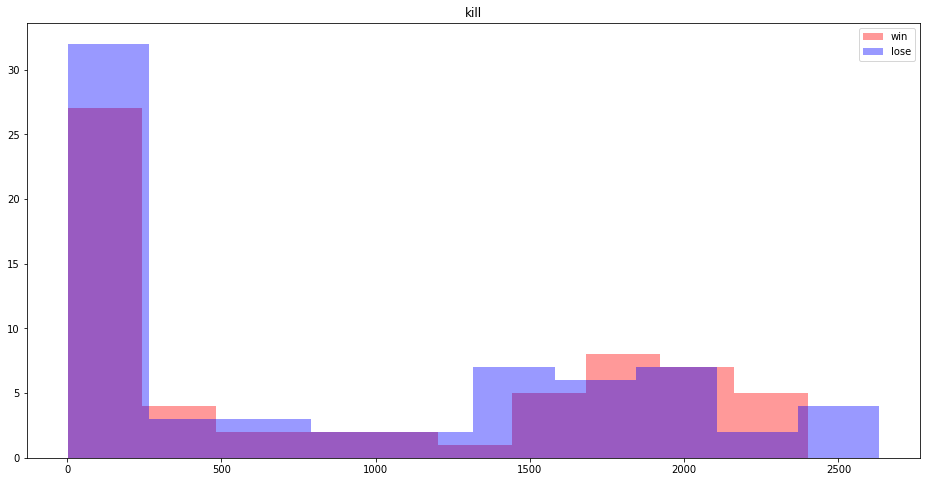

In [54]:
hist_plotter('kill')

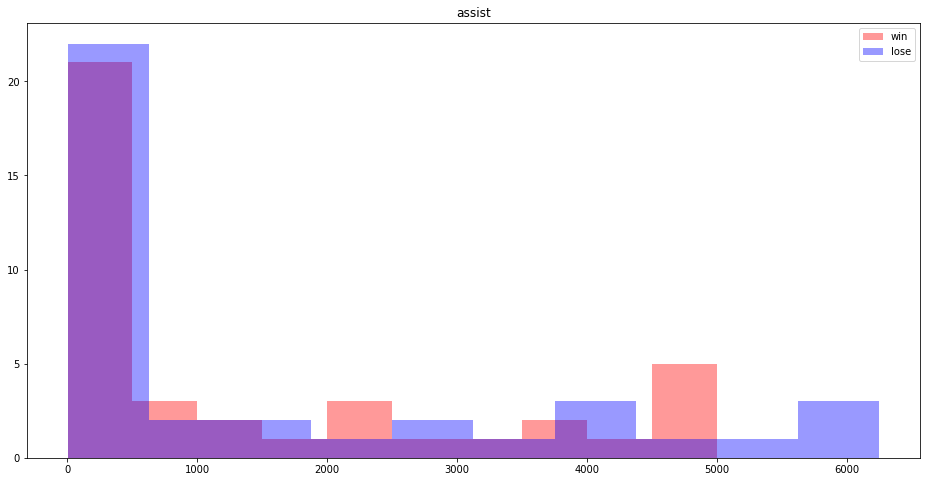

In [55]:
hist_plotter('assist')

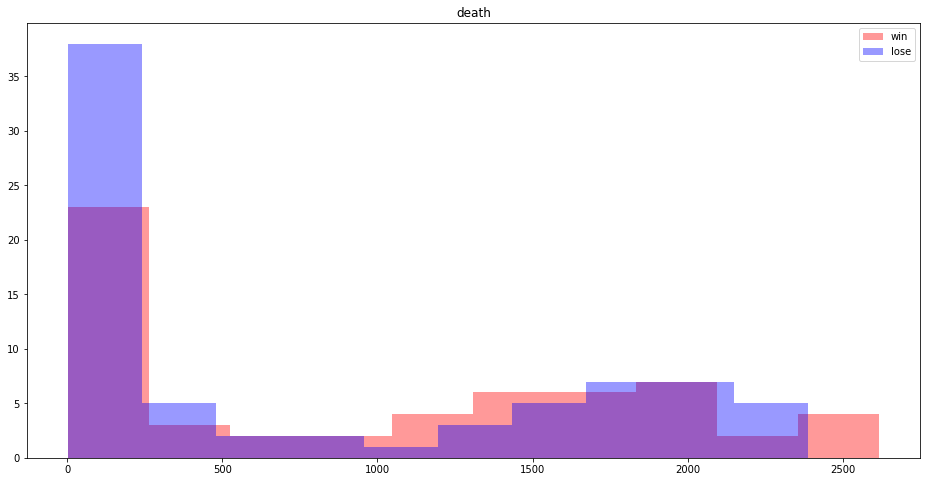

In [56]:
hist_plotter('death')

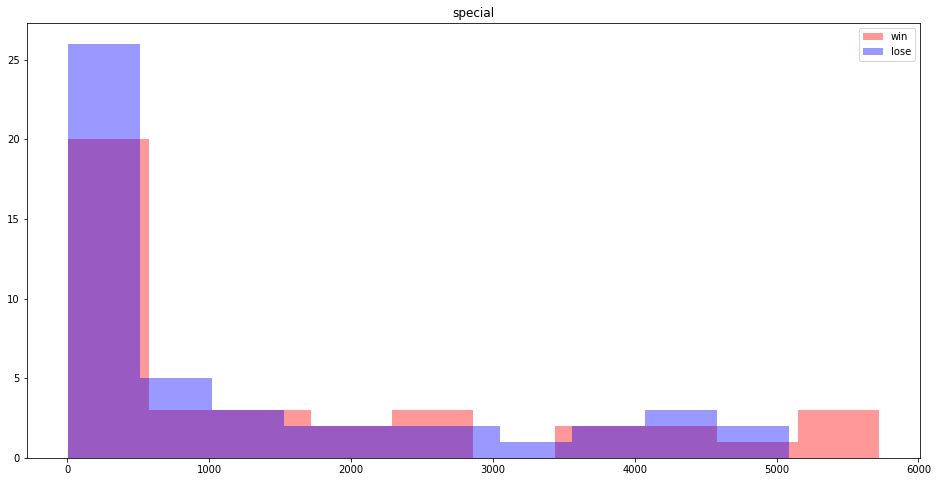

In [57]:
hist_plotter('special')

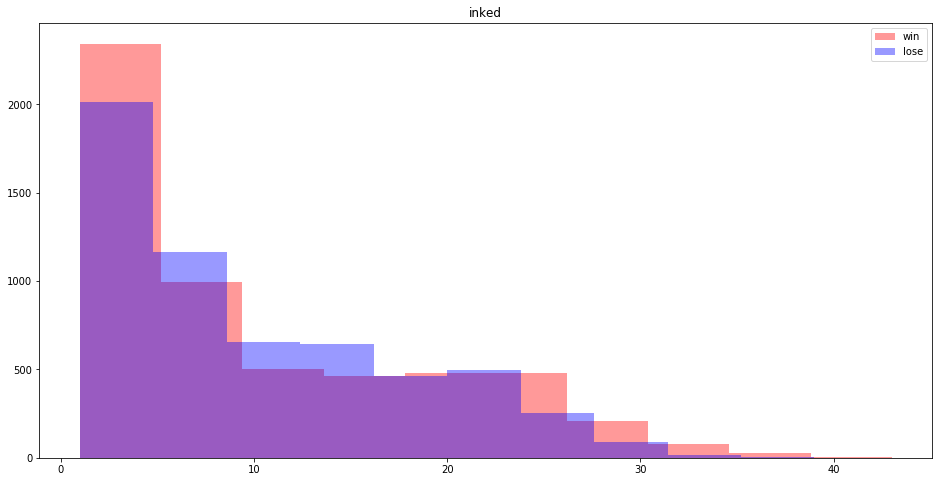

In [58]:
hist_plotter('inked')

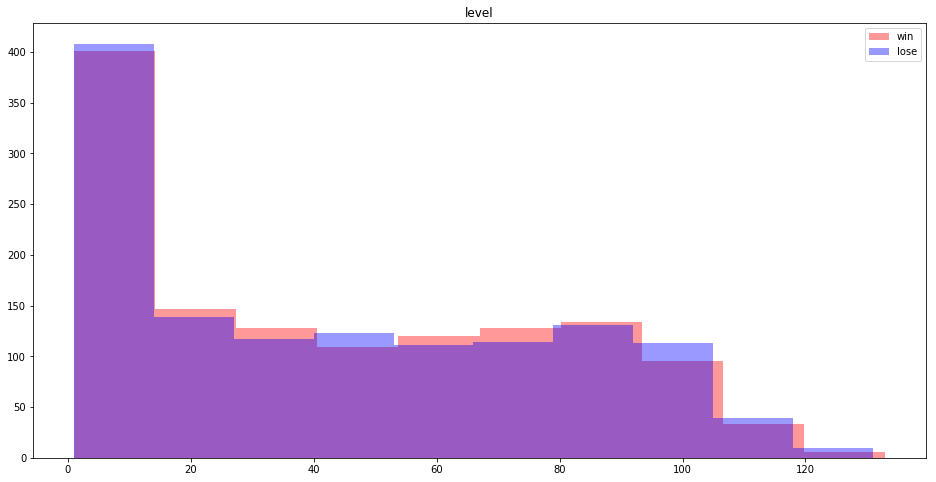

In [59]:
hist_plotter('level')

In [62]:
# split into features and label
X = df[['mode', 'kill', 'assist', 'death', 'special', 'inked', 'level']]
y = df['win']
# make dummies of game type
X = pd.get_dummies(X)
# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [63]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8019275950448527

In [64]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8007261853908586

In [65]:
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, subsample=0.5, max_depth=3,
                                min_impurity_decrease=0)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.8037697565143102

In [110]:
gdbr_grid = {'learning_rate': [0.01, 0.05, 0.1],
             'max_depth': [10, 3, 1],
             'subsample': [1, 0.5],
             'min_impurity_decrease': [0, 0.01],
             'n_estimators': [1000, 100, 10],
             'random_state': [1]}

gdbr_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                               gdbr_grid,
                               n_jobs=-1,
                               cv = 3,
                               verbose=True,
                               scoring='accuracy')
gdbr_gridsearch.fit(X_train, y_train)

print("best parameters:", gdbr_gridsearch.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 18.5min finished


best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_impurity_decrease': 0, 'n_estimators': 1000, 'random_state': 1, 'subsample': 0.5}


In [68]:
model = Sequential()
model.add(Dense(units=10, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=100)

Train on 76046 samples
Epoch 1/10
76046/76046 [==============================] - 1s 15us/sample - loss: 0.5018 - accuracy: 0.7536
Epoch 2/10
76046/76046 [==============================] - 1s 14us/sample - loss: 0.4259 - accuracy: 0.8037s -
Epoch 3/10
76046/76046 [==============================] - 1s 12us/sample - loss: 0.4176 - accuracy: 0.8057
Epoch 4/10
76046/76046 [==============================] - 1s 13us/sample - loss: 0.4141 - accuracy: 0.8062
Epoch 5/10
76046/76046 [==============================] - 1s 12us/sample - loss: 0.4119 - accuracy: 0.8068
Epoch 6/10
76046/76046 [==============================] - 1s 13us/sample - loss: 0.4103 - accuracy: 0.8067
Epoch 7/10
76046/76046 [==============================] - 1s 13us/sample - loss: 0.4093 - accuracy: 0.8070
Epoch 8/10
76046/76046 [==============================] - 1s 12us/sample - loss: 0.4083 - accuracy: 0.8079
Epoch 9/10
76046/76046 [==============================] - 1s 12us/sample - loss: 0.4077 - accuracy: 0.8080
Epoch 10/10

In [69]:
y_pred = model.predict_classes(X_test)
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.8047575822298163 0.8161442441054092 0.7862640299305185


array([[15432,  3314],
       [ 3999, 14711]])